In [ ]:
# Import necessary libraries
import pandas as pd

# Load the dataset
file_path = '/content/Preprocessed Fake Reviews Detection Dataset(1).csv'  # Replace with the correct path
df = pd.read_csv(file_path)

# Check the data
print("Dataset Head:")
print(df.head())

print("\nDataset Information:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Dataset Head:
   Unnamed: 0            category  rating label  \
0           0  Home_and_Kitchen_5     5.0    CG   
1           1  Home_and_Kitchen_5     5.0    CG   
2           2  Home_and_Kitchen_5     5.0    CG   
3           3  Home_and_Kitchen_5     1.0    CG   
4           4  Home_and_Kitchen_5     5.0    CG   

                                          text_  
0     love well made sturdi comfort love pretti  
1  love great upgrad origin 've mine coupl year  
2        pillow save back love look feel pillow  
3           miss inform use great product price  
4           nice set good qualiti set two month  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  40432 non-null  int64  
 1   category    40432 non-null  object 
 2   rating      40432 non-null  float64
 3   label       40432 non-null  object 
 4 

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

# Load stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Rejoin tokens
    return ' '.join(tokens)

# Apply preprocessing to the 'text_' column
tqdm.pandas()  # Enable progress bar for Pandas
df['cleaned_text'] = df['text_'].progress_apply(preprocess_text)

# Drop rows with empty 'cleaned_text'
df = df[df['cleaned_text'].str.strip() != ""]

# Check the cleaned data
print(df['cleaned_text'].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
100%|██████████| 40432/40432 [00:21<00:00, 1871.49it/s]

0    love well made sturdi comfort love pretti
1     love great upgrad origin mine coupl year
2       pillow save back love look feel pillow
3          miss inform use great product price
4          nice set good qualiti set two month
Name: cleaned_text, dtype: object


In [ ]:
# Save the 'cleaned_text' column to a CSV file
df[['cleaned_text']].to_csv('cleaned_text.csv', index=False)

print("cleaned_text.csv has been saved successfully.")


cleaned_text.csv has been saved successfully.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize the text using CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')  # Adjust max_df and min_df if needed
dtm = vectorizer.fit_transform(df['cleaned_text'])

# Check the shape of the document-term matrix
print(f"Document-Term Matrix Shape: {dtm.shape}")


Document-Term Matrix Shape: (40431, 15720)


**LDA Model Training**

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Number of topics (can be tuned based on results)
num_topics = 5

# Initialize the LDA model
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42, max_iter=10)

# Fit the LDA model to the document-term matrix
lda_model.fit(dtm)

# Get the words for each topic
words = vectorizer.get_feature_names_out()

# Display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

# Number of top words to display per topic
num_top_words = 10
display_topics(lda_model, words, num_top_words)


Topic 1:
use, great, good, work, easi, light, nice, littl, product, love

Topic 2:
nt, use, work, like, need, time, make, realli, tri, set

Topic 3:
book, read, stori, charact, love, good, enjoy, like, great, seri

Topic 4:
movi, good, stori, nt, watch, film, act, like, great, love

Topic 5:
love, dog, great, size, fit, littl, like, wear, bought, nt



In [ ]:
pip install gensim pyLDAvis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.7 MB/s eta 0:00:00


In [ ]:
pip install pyLDAvis gensim


In [ ]:
import pyLDAvis.gensim_models


**LDA Coherence Check**

In [ ]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import pyLDAvis
import pyLDAvis.gensim_models  # Correct import for Gensim models
from gensim.models.ldamodel import LdaModel

# Convert document-term matrix to Gensim format
corpus = [doc.split() for doc in df['cleaned_text']]
id2word = Dictionary(corpus)
gensim_corpus = [id2word.doc2bow(text) for text in corpus]

# Create the Gensim LDA model for coherence calculation
num_topics = 5  # Adjust based on your dataset and requirements
gensim_lda = LdaModel(corpus=gensim_corpus, id2word=id2word, num_topics=num_topics, passes=10, random_state=42)

# Compute coherence score
coherence_model = CoherenceModel(model=gensim_lda, texts=corpus, dictionary=id2word, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"Topic Coherence Score: {coherence_score:.4f}")

# Visualize topics using pyLDAvis
lda_visualization = pyLDAvis.gensim_models.prepare(gensim_lda, gensim_corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_visualization)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic Coherence Score: 0.5813


In [ ]:
from gensim.models.coherencemodel import CoherenceModel

# Compute Perplexity
perplexity = gensim_lda.log_perplexity(gensim_corpus)
print(f"LDA Perplexity: {perplexity:.4f}")

# Compute Coherence Score
coherence_model = CoherenceModel(model=gensim_lda, texts=corpus, dictionary=id2word, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"LDA Coherence Score: {coherence_score:.4f}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LDA Perplexity: -7.4527
LDA Coherence Score: 0.5813


In [ ]:
# Extract and display the top words for each topic
num_words = 10  # Number of top words to display
topics = gensim_lda.show_topics(num_topics=5, num_words=num_words, formatted=False)

# Print topics with their top words
for topic_num, words in topics:
    print(f"Topic {topic_num}: ", [word[0] for word in words])


Topic 0:  ['fit', 'size', 'wear', 'comfort', 'shoe', 'order', 'look', 'littl', 'like', 'would']
Topic 1:  ['nt', 'end', 'get', 'interest', 'go', 'dog', 'game', 'could', 'like', 'one']
Topic 2:  ['book', 'read', 'stori', 'love', 'charact', 'good', 'enjoy', 'well', 'like', 'great']
Topic 3:  ['nt', 'work', 'use', 'one', 'even', 'need', 'much', 'review', 'get', 'ring']
Topic 4:  ['love', 'great', 'bought', 'one', 'littl', 'would', 'use', 'good', 'son', 'year']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


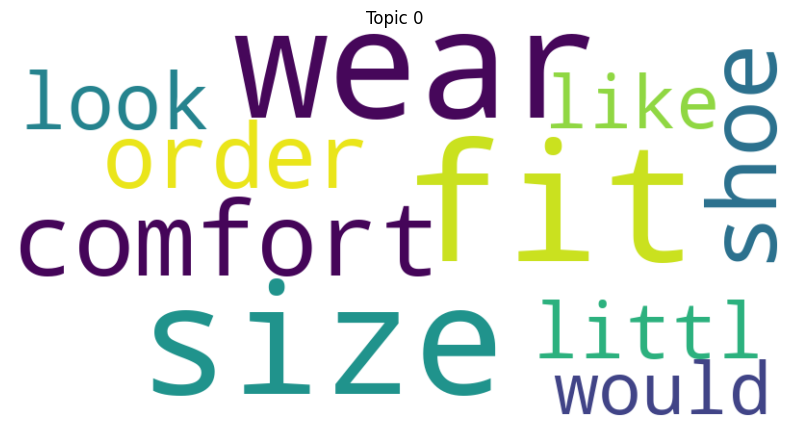

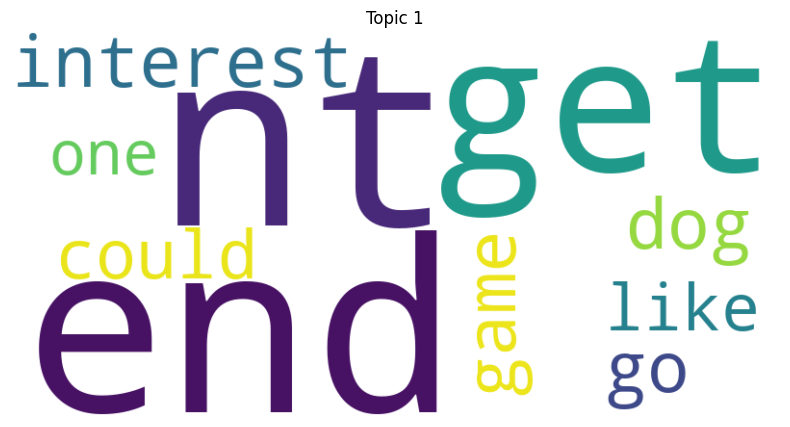

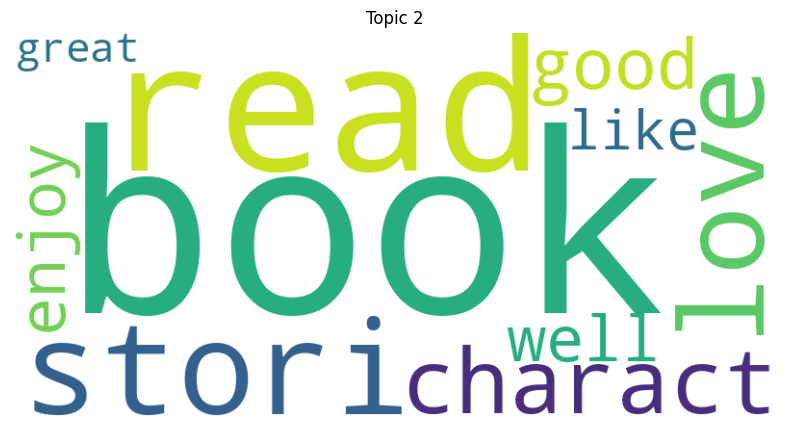

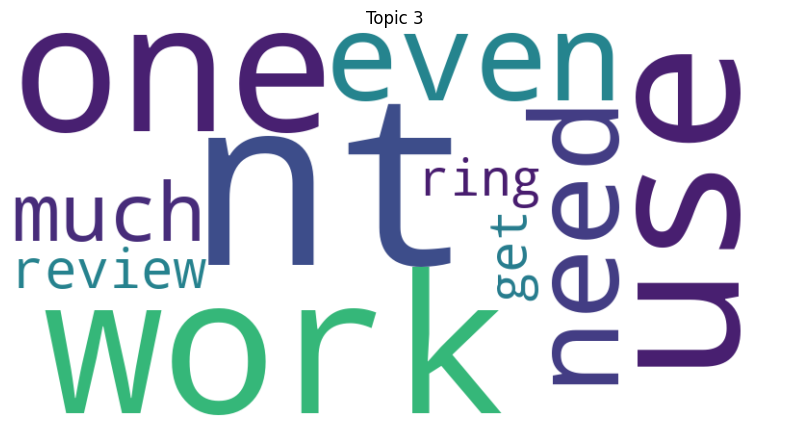

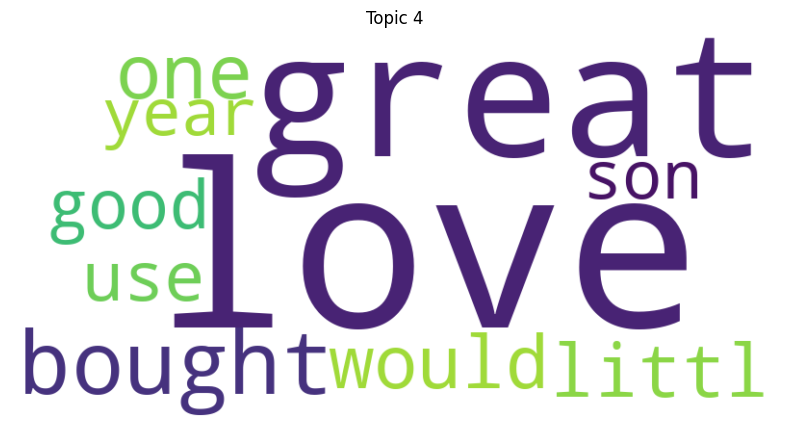

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate a word cloud for each topic
for topic_num, words in topics:
    word_dict = {word[0]: word[1] for word in words}  # Convert to a dictionary
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {topic_num}")
    plt.show()


**NMF MODEL**

In [ ]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 1: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# Step 2: Apply NMF
num_topics = 5  # Adjust as needed
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_topics = nmf_model.fit_transform(tfidf)

# Step 3: Display topics
terms = tfidf_vectorizer.get_feature_names_out()
for idx, topic in enumerate(nmf_model.components_):
    print(f"Topic #{idx + 1}:")
    print([terms[i] for i in topic.argsort()[-10:]])


Topic #1:
['develop', 'nt', 'good', 'author', 'seri', 'enjoy', 'charact', 'stori', 'read', 'book']
Topic #2:
['good', 'like', 'price', 'light', 'easi', 'product', 'nt', 'work', 'great', 'use']
Topic #3:
['action', 'enjoy', 'great', 'like', 'film', 'stori', 'act', 'watch', 'good', 'movi']
Topic #4:
['christma', 'year', 'old', 'daughter', 'play', 'bought', 'toy', 'son', 'dog', 'love']
Topic #5:
['small', 'perfect', 'littl', 'order', 'shoe', 'nice', 'wear', 'comfort', 'size', 'fit']


**ADDING LABELS**

In [ ]:
topic_labels = {
    1: "Book Reviews",
    2: "Product Reviews",
    3: "Movie Reviews",
    4: "Christmas Gifts",
    5: "Clothing & Shoes",
}

df['nmf_topic'] = nmf_topics.argmax(axis=1)
df['nmf_topic_label'] = df['nmf_topic'].map(topic_labels)


In [ ]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'df' contains your preprocessed text in a column 'cleaned_text'
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# Define and fit the NMF model
num_topics = 5  # You can choose the number of topics based on your needs
nmf = NMF(n_components=num_topics, random_state=42)
nmf.fit(tfidf_matrix)


NMF(n_components=5, random_state=42)

In [ ]:
# Extract top words for each topic
top_words = []
for topic_idx, topic in enumerate(nmf.components_):
    top_words.append([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

# Display the top words for each topic
for idx, words in enumerate(top_words):
    print(f"Topic {idx + 1}: {', '.join(words)}")


Topic 1: nt, develop, good, author, seri, enjoy, charact, stori, read, book
Topic 2: qualiti, good, price, light, easi, nt, product, work, great, use
Topic 3: action, enjoy, great, film, like, stori, act, watch, good, movi
Topic 4: christma, year, old, daughter, bought, play, toy, dog, son, love
Topic 5: materi, littl, perfect, nice, order, shoe, wear, comfort, size, fit


**ANALYSE TOPIC DISTRIBUTION**

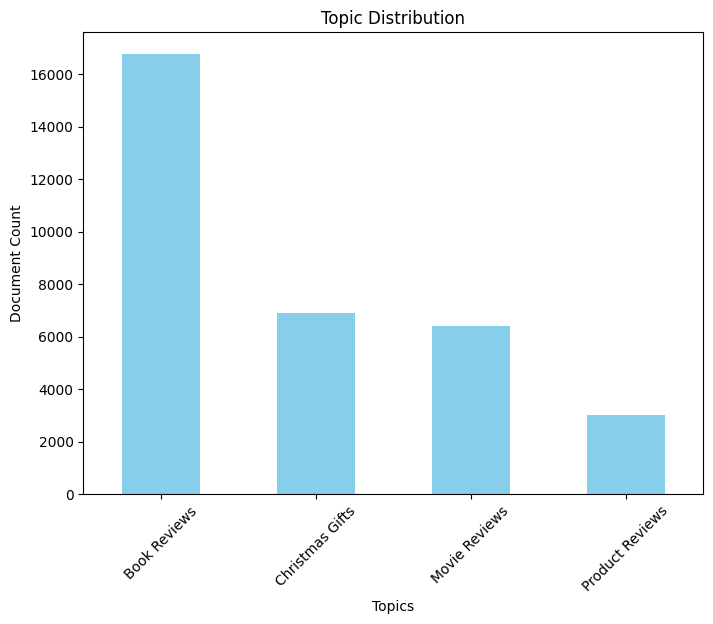

In [ ]:
# Count topic occurrences
topic_counts = df['nmf_topic_label'].value_counts()

# Plot the distribution
topic_counts.plot(kind='bar', figsize=(8, 6), color='skyblue')
plt.title('Topic Distribution')
plt.xlabel('Topics')
plt.ylabel('Document Count')
plt.xticks(rotation=45)
plt.show()


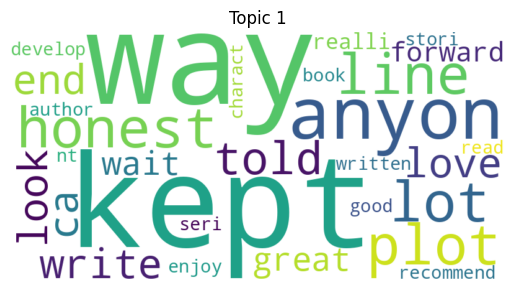

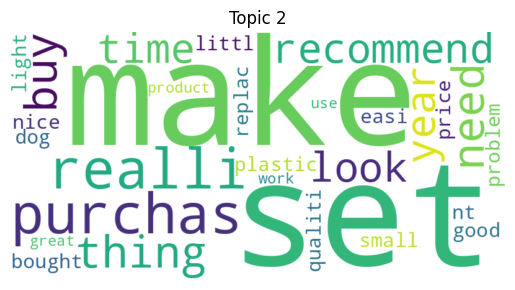

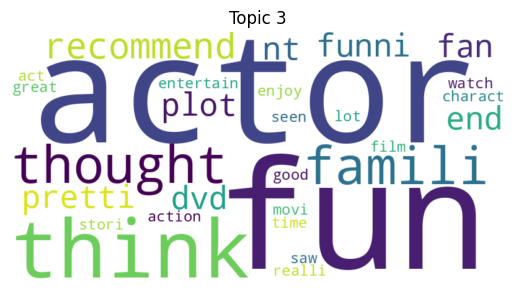

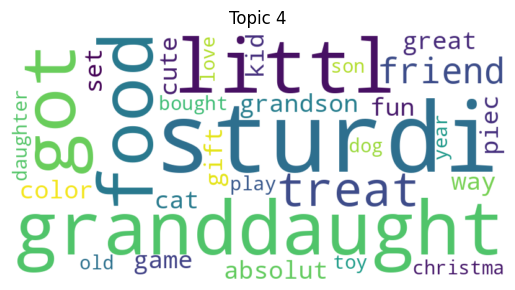

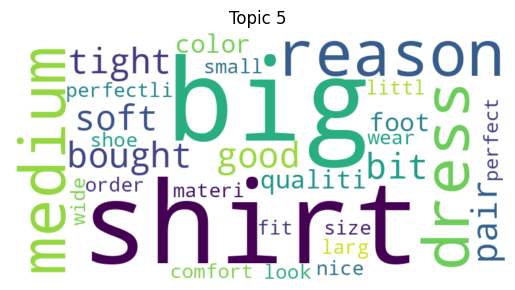

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for idx, topic in enumerate(nmf.components_):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(
        ' '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-30:]])
    )
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {idx + 1}")
    plt.show()


**EVALUATION OF RESULTS**

In [ ]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# Prepare data for coherence calculation
texts = [doc.split() for doc in df['cleaned_text']]
id2word = Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

# Extract top words for each topic
top_words = []
for topic_idx, topic in enumerate(nmf.components_):
    top_words.append([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

# Compute coherence score
coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=id2word, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"NMF Coherence Score: {coherence_score:.4f}")


NMF Coherence Score: 0.6852


In [ ]:
from textblob import TextBlob

df['sentiment'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
topic_sentiment = df.groupby('nmf_topic_label')['sentiment'].mean()
print("Average Sentiment by Topic:")
print(topic_sentiment)


Average Sentiment by Topic:
nmf_topic_label
Book Reviews       0.251197
Christmas Gifts    0.280600
Movie Reviews      0.349833
Product Reviews    0.314069
Name: sentiment, dtype: float64


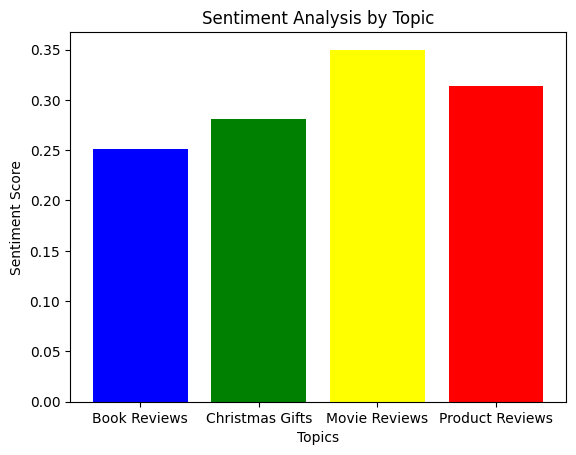

In [ ]:
import matplotlib.pyplot as plt

topics = ['Book Reviews', 'Christmas Gifts', 'Movie Reviews', 'Product Reviews']
sentiment_scores = [0.251197, 0.280600, 0.349833, 0.314069]

plt.bar(topics, sentiment_scores, color=['blue', 'green', 'Yellow', 'red'])
plt.xlabel('Topics')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Analysis by Topic')
plt.show()


In [ ]:
# Assuming 'df' contains your preprocessed text in a column 'cleaned_text'

# Use the SAME max_features for both training and transformation
max_features = 5000  # Or 1000 if you prefer that dimensionality

# Create the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')

# Fit the vectorizer and transform the data
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# Define and fit the NMF model
num_topics = 5
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(tfidf_matrix)

# Now, you can transform the data using the same tfidf_matrix
document_topic_matrix = nmf_model.transform(tfidf_matrix)

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(document_topic_matrix)


In [ ]:
from sklearn.cluster import KMeans

# Define the number of clusters (e.g., same as topics)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(document_topic_matrix)


In [ ]:
from sklearn.metrics import silhouette_score

silhouette = silhouette_score(document_topic_matrix, kmeans_labels)
print(f"Silhouette Score: {silhouette:.4f}")


Silhouette Score: 0.4461


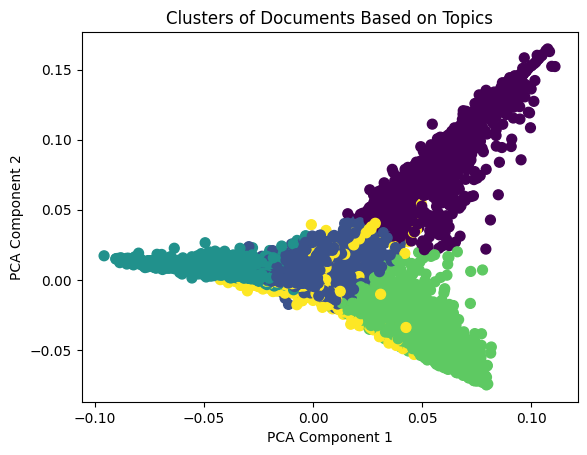

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(document_topic_matrix)

# Scatter plot of clusters
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title("Clusters of Documents Based on Topics")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


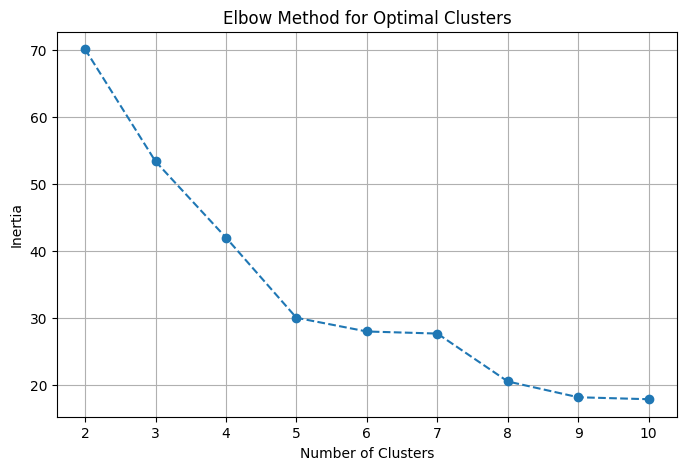

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define a range for the number of clusters
cluster_range = range(2, 11)  # Testing from 2 to 10 clusters
inertia = []

# Compute inertia for each number of clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(document_topic_matrix)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.xticks(cluster_range)
plt.grid()
plt.show()
